In [ ]:
!pip install torch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 111.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 88.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 57.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 86.9 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitli

In [ ]:
!pip install transformers

In [ ]:
import numpy as np
import pandas as pd

#data visualisation libraries
import matplotlib.pyplot as plt
import seaborn as sns
from pylab import rcParams

import torch
from torch.utils.data import DataLoader, TensorDataset
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score

#to avoid warnings
import warnings
warnings.filterwarnings('ignore')


In [ ]:
data = pd.read_csv("/content/sample_data/train.csv")
print(data.head())


                 id                                       comment_text  toxic  \
0  0000997932d777bf  Explanation\nWhy the edits made under my usern...      0   
1  000103f0d9cfb60f  D'aww! He matches this background colour I'm s...      0   
2  000113f07ec002fd  Hey man, I'm really not trying to edit war. It...      0   
3  0001b41b1c6bb37e  "\nMore\nI can't make any real suggestions on ...      0   
4  0001d958c54c6e35  You, sir, are my hero. Any chance you remember...      0   

   severe_toxic  obscene  threat  insult  identity_hate  
0             0        0       0       0              0  
1             0        0       0       0              0  
2             0        0       0       0              0  
3             0        0       0       0              0  
4             0        0       0       0              0  


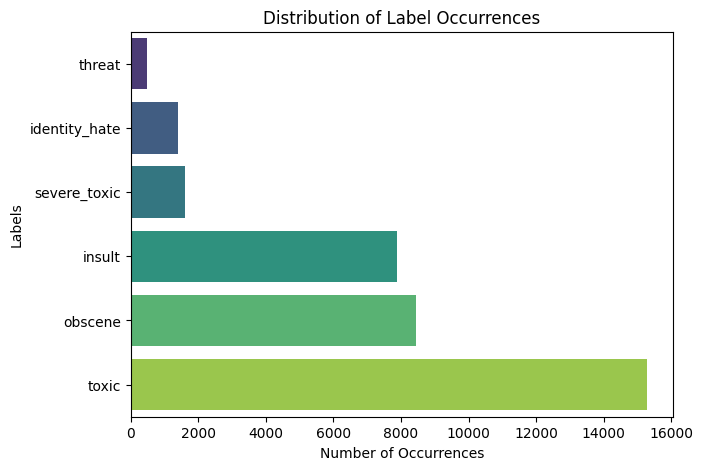

In [ ]:
# Visualizing the class distribution of the 'label' column
column_labels = data.columns.tolist()[2:]
label_counts = data[column_labels].sum().sort_values()


# Create a black background for the plot
plt.figure(figsize=(7, 5))

# Create a horizontal bar plot using Seaborn
ax = sns.barplot(x=label_counts.values,
				y=label_counts.index, palette='viridis')


# Add labels and title to the plot
plt.xlabel('Number of Occurrences')
plt.ylabel('Labels')
plt.title('Distribution of Label Occurrences')

# Show the plot
plt.show()


In [ ]:
data[column_labels].sum().sort_values()


,0
threat,478
identity_hate,1405
severe_toxic,1595
insult,7877
obscene,8449
toxic,15294


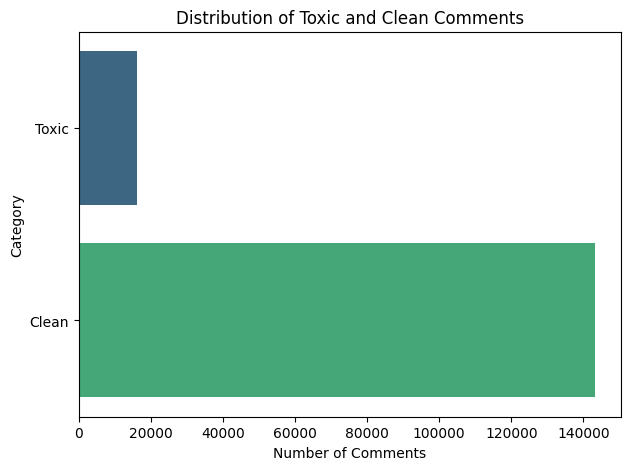

In [ ]:
# Create subsets based on toxic and clean comments
train_toxic = data[data[column_labels].sum(axis=1) > 0]
train_clean = data[data[column_labels].sum(axis=1) == 0]

# Number of toxic and clean comments
num_toxic = len(train_toxic)
num_clean = len(train_clean)

# Create a DataFrame for visualization
plot_data = pd.DataFrame(
	{'Category': ['Toxic', 'Clean'], 'Count': [num_toxic, num_clean]})

# Create a black background for the plot
plt.figure(figsize=(7, 5))

# Horizontal bar plot
ax = sns.barplot(x='Count', y='Category', data=plot_data, palette='viridis')


# Add labels and title to the plot
plt.xlabel('Number of Comments')
plt.ylabel('Category')
plt.title('Distribution of Toxic and Clean Comments')

# Set ticks' color to white
ax.tick_params()

# Show the plot
plt.show()


In [ ]:
print(train_toxic.shape)
print(train_clean.shape)


(16225, 8)
(143346, 8)


In [ ]:
# Randomly sample 15,000 clean comments
train_clean_sampled = train_clean.sample(n=16225, random_state=42)

# Combine the toxic and sampled clean comments
dataframe = pd.concat([train_toxic, train_clean_sampled], axis=0)

# Shuffle the data to avoid any order bias during training
dataframe = data.sample(frac=1, random_state=42)


In [ ]:
print(train_toxic.shape)
print(train_clean_sampled.shape)
print(dataframe.shape)


(16225, 8)
(16225, 8)
(159571, 8)


In [ ]:
# Split data into training, testing sets & validation sets
train_texts, test_texts, train_labels, test_labels = train_test_split(
	dataframe['comment_text'], dataframe.iloc[:, 2:], test_size=0.25, random_state=42)


In [ ]:
# validation set
test_texts, val_texts, test_labels, val_labels = train_test_split(
	test_texts, test_labels, test_size=0.5, random_state=42)


In [ ]:
# Token and Encode Function
def tokenize_and_encode(tokenizer, comments, labels, max_length=128):
	# Initialize empty lists to store tokenized inputs and attention masks
	input_ids = []
	attention_masks = []

	# Iterate through each comment in the 'comments' list
	for comment in comments:

		# Tokenize and encode the comment using the BERT tokenizer
		encoded_dict = tokenizer.encode_plus(
			comment,

			# Add special tokens like [CLS] and [SEP]
			add_special_tokens=True,

			# Truncate or pad the comment to 'max_length'
			max_length=max_length,

			# Pad the comment to 'max_length' with zeros if needed
			pad_to_max_length=True,

			# Return attention mask to mask padded tokens
			return_attention_mask=True,

			# Return PyTorch tensors
			return_tensors='pt'
		)

		# Append the tokenized input and attention mask to their respective lists
		input_ids.append(encoded_dict['input_ids'])
		attention_masks.append(encoded_dict['attention_mask'])

	# Concatenate the tokenized inputs and attention masks into tensors
	input_ids = torch.cat(input_ids, dim=0)
	attention_masks = torch.cat(attention_masks, dim=0)

	# Convert the labels to a PyTorch tensor with the data type float32
	labels = torch.tensor(labels, dtype=torch.float32)

	# Return the tokenized inputs, attention masks, and labels as PyTorch tensors
	return input_ids, attention_masks, labels


In [ ]:
# Token Initialization
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased',
										do_lower_case=True)


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
# Model Initialization
model = BertForSequenceClassification.from_pretrained('bert-base-uncased',
													num_labels=6)


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:

# Move model to GPU if available
device = torch.device(
	'cuda') if torch.cuda.is_available() else torch.device('cpu')
model = model.to(device)


In [ ]:
# Tokenize and Encode the comments and labels for the training set
input_ids, attention_masks, labels = tokenize_and_encode(
	tokenizer,
	train_texts,
	train_labels.values
)

# Tokenize and Encode the comments and labels for the test set
test_input_ids, test_attention_masks, test_labels = tokenize_and_encode(
	tokenizer,
	test_texts,
	test_labels.values
)

# Tokenize and Encode the comments and labels for the validation set
val_input_ids, val_attention_masks, val_labels = tokenize_and_encode(
	tokenizer,
	val_texts,
	val_labels.values
)


print('Training Comments :',train_texts.shape)
print('Input Ids		 :',input_ids.shape)
print('Attention Mask :',attention_masks.shape)
print('Labels		 :',labels.shape)


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Training Comments : (119678,)
Input Ids		 : torch.Size([119678, 128])
Attention Mask : torch.Size([119678, 128])
Labels		 : torch.Size([119678, 6])


In [ ]:
k = 53
print('Training Comments -->>',train_texts.values[k])
print('\nInput Ids -->>\n',input_ids[k])
print('\nDecoded Ids -->>\n',tokenizer.decode(input_ids[k]))
print('\nAttention Mask -->>\n',attention_masks[k])
print('\nLabels -->>',labels[k])


Training Comments -->> "Manually.    Ping me 

"

Input Ids -->>
 tensor([  101,  1000, 21118,  1012, 17852,  2033,  1000,   102,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0

In [ ]:
# Creating DataLoader for the balanced dataset
batch_size = 32
train_dataset = TensorDataset(input_ids, attention_masks, labels)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# testing set
test_dataset = TensorDataset(test_input_ids, test_attention_masks, test_labels)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# validation set
val_dataset = TensorDataset(val_input_ids, val_attention_masks, val_labels)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)


In [ ]:
print('Batch Size :',train_loader.batch_size)
Batch =next(iter(train_loader))
print('Each Input ids shape :',Batch[0].shape)
print('Input ids :\n',Batch[0][0])
print('Corresponding Decoded text:\n',tokenizer.decode(Batch[0][0]))
print('Corresponding Attention Mask :\n',Batch[1][0])
print('Corresponding Label:',Batch[2][0])


Batch Size : 32
Each Input ids shape : torch.Size([32, 128])
Input ids :
 tensor([  101, 11693,  2000, 11234,  1012,  2009,  2003,  1996,  2590,  2518,
         1012,  3531,  3437,  2026,  3160,  1012,  4283,  1011,  1006, 24501,
        21149,  1007,   102,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     

In [ ]:
# Optimizer setup
optimizer = AdamW(model.parameters(), lr=2e-5)


In [ ]:
# Function to Train the Model
def train_model(model, train_loader, optimizer, device, num_epochs):
	# Loop through the specified number of epochs
	for epoch in range(num_epochs):
		# Set the model to training mode
		model.train()
		# Initialize total loss for the current epoch
		total_loss = 0

		# Loop through the batches in the training data
		for batch in train_loader:
			input_ids, attention_mask, labels = [t.to(device) for t in batch]

			optimizer.zero_grad()

			outputs = model(
				input_ids, attention_mask=attention_mask, labels=labels)
			loss = outputs.loss
			total_loss += loss.item()

			loss.backward()
			optimizer.step()

		model.eval() # Set the model to evaluation mode
		val_loss = 0

		# Disable gradient computation during validation
		with torch.no_grad():
			for batch in val_loader:
				input_ids, attention_mask, labels = [
					t.to(device) for t in batch]

				outputs = model(
					input_ids, attention_mask=attention_mask, labels=labels)
				loss = outputs.loss
				val_loss += loss.item()
		# Print the average loss for the current epoch
		print(
			f'Epoch {epoch+1}, Training Loss: {total_loss/len(train_loader)},Validation loss:{val_loss/len(val_loader)}')


# Call the function to train the model
train_model(model, train_loader, optimizer, device, num_epochs=3)


Epoch 1, Training Loss: 0.05352697831287203,Validation loss:0.043125795206064
Epoch 2, Training Loss: 0.03465617479532982,Validation loss:0.038790659004847
Epoch 3, Training Loss: 0.027383545385816825,Validation loss:0.04162922546623658


In [ ]:
# Evaluate the Model
def evaluate_model(model, test_loader, device):
	model.eval() # Set the model to evaluation mode

	true_labels = []
	predicted_probs = []

	with torch.no_grad():
		for batch in test_loader:
			input_ids, attention_mask, labels = [t.to(device) for t in batch]

			# Get model's predictions
			outputs = model(input_ids, attention_mask=attention_mask)
			# Use sigmoid for multilabel classification
			predicted_probs_batch = torch.sigmoid(outputs.logits)
			predicted_probs.append(predicted_probs_batch.cpu().numpy())

			true_labels_batch = labels.cpu().numpy()
			true_labels.append(true_labels_batch)

	# Combine predictions and labels for evaluation
	true_labels = np.concatenate(true_labels, axis=0)
	predicted_probs = np.concatenate(predicted_probs, axis=0)
	predicted_labels = (predicted_probs > 0.5).astype(
		int) # Apply threshold for binary classification

	# Calculate evaluation metrics
	accuracy = accuracy_score(true_labels, predicted_labels)
	precision = precision_score(true_labels, predicted_labels, average='micro')
	recall = recall_score(true_labels, predicted_labels, average='micro')

	# Print the evaluation metrics
	print(f'Accuracy: {accuracy:.4f}')
	print(f'Precision: {precision:.4f}')
	print(f'Recall: {recall:.4f}')


# Call the function to evaluate the model on the test data
evaluate_model(model, test_loader, device)


Accuracy: 0.9242
Precision: 0.7875
Recall: 0.7875


In [ ]:
# Save the tokenizer and model in the same directory
output_dir = "Saved_model"
# Save model's state dictionary and configuration
model.save_pretrained(output_dir)
# Save tokenizer's configuration and vocabulary
tokenizer.save_pretrained(output_dir)


('Saved_model/tokenizer_config.json',
 'Saved_model/special_tokens_map.json',
 'Saved_model/vocab.txt',
 'Saved_model/added_tokens.json')

In [ ]:
# Load the tokenizer and model from the saved directory
model_name = "Saved_model"
Bert_Tokenizer = BertTokenizer.from_pretrained(model_name)
Bert_Model = BertForSequenceClassification.from_pretrained(
	model_name).to(device)


In [ ]:
def predict_user_input(input_text, model=Bert_Model, tokenizer=Bert_Tokenizer, device=device):
	user_input = [input_text]

	user_encodings = tokenizer(
		user_input, truncation=True, padding=True, return_tensors="pt")

	user_dataset = TensorDataset(
		user_encodings['input_ids'], user_encodings['attention_mask'])

	user_loader = DataLoader(user_dataset, batch_size=1, shuffle=False)

	model.eval()
	with torch.no_grad():
		for batch in user_loader:
			input_ids, attention_mask = [t.to(device) for t in batch]
			outputs = model(input_ids, attention_mask=attention_mask)
			logits = outputs.logits
			predictions = torch.sigmoid(logits)

	predicted_labels = (predictions.cpu().numpy() > 0.5).astype(int)
	labels_list = ['toxic', 'severe_toxic', 'obscene',
				'threat', 'insult', 'identity_hate']
	result = dict(zip(labels_list, predicted_labels[0]))
	return result


text = 'Are you insane!'
predict_user_input(input_text=text)


{'toxic': np.int64(1),
 'severe_toxic': np.int64(0),
 'obscene': np.int64(0),
 'threat': np.int64(0),
 'insult': np.int64(1),
 'identity_hate': np.int64(0)}

In [ ]:
import streamlit as st
import torch
from transformers import BertTokenizer, BertForSequenceClassification
import numpy as np

def load_model():
    model_name = "Saved_model"
    tokenizer = BertTokenizer.from_pretrained(model_name)
    model = BertForSequenceClassification.from_pretrained(model_name)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    model.eval()
    return model, tokenizer, device

def predict_toxicity(text, model, tokenizer, device):
    encodings = tokenizer([text], truncation=True, padding=True, return_tensors="pt")
    input_ids = encodings['input_ids'].to(device)
    attention_mask = encodings['attention_mask'].to(device)

    with torch.no_grad():
        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        predictions = torch.sigmoid(logits)

    predicted_labels = (predictions.cpu().numpy() > 0.5).astype(int)
    labels_list = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
    result = dict(zip(labels_list, predicted_labels[0]))
    return result

st.title("Toxicity Detection using BERT")
st.write("Enter a comment to analyze its toxicity levels.")

model, tokenizer, device = load_model()

user_input = st.text_area("Enter text:")

if st.button("Analyze"):
    if user_input:
        result = predict_toxicity(user_input, model, tokenizer, device)
        st.subheader("Prediction:")
        for label, value in result.items():
            st.write(f"{label}: {'Yes' if value else 'No'}")
    else:
        st.warning("Please enter some text.")


2025-03-19 08:57:56.477 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-03-19 08:57:56.478 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-03-19 08:57:56.479 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-03-19 08:57:56.480 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-03-19 08:57:56.481 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-03-19 08:57:56.481 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-03-19 08:57:56.733 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-03-19 08:57:56.734 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bar

In [ ]:
from google.colab import files
files.download('/content/Saved_model/model.safetensors')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>